## Import and preprocess datasets

In [1]:
import numpy as np
from netCDF4 import Dataset
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from sklearn.ensemble.forest import RandomForestRegressor, RandomForestClassifier
import os
from sklearn import preprocessing, metrics
from importlib import reload
import sknn.mlp
from sklearn import tree  #for graphing random forest tree
import pickle
%matplotlib inline
pylab.rcParams['figure.figsize'] = (10, 6)
inline_rc = dict(mpl.rcParams)
import src.nnload as nnload
import src.nntrain as nntrain
import src.nnplot as nnplot

# Set script parameters
minlev = 0.0
rainonly = False
write_nn_to_netcdf = False
fig_dir = './figs/'
data_dir = './data/'

In [88]:
# Load data
reload(nnload)
x, y, cv, Pout, lat, lev, dlev, timestep = nnload.loaddata(data_dir + 'nntest.nc', minlev,
                                                       rainonly=rainonly) #,all_lats=False,indlat=8)
# Preprocess data
scaler_x, scaler_y, x1, x2, x3, y1, y2, y3, cv1, cv2, cv3 = nnload.pp(x, y, cv, 30000)

/Users/jgdwyer/Dropbox (MIT)/scripts/nn/src/nnload.py:68: UserWarning: Shifting inputs and outputs one time step so they line up!
  warnings.warn("Shifting inputs and outputs one time step so they line up!")


There is some amount of rain 61.0% of the time
There is a rate of >3 mm/day 20.2% of the time
There is convection 65.5% of the time


In [ ]:
scaler_x, scaler_y, x1, x2, x3, y1, y2, y3, cv1, cv2, cv3 = nnload.pp(x, y, cv)
    # Normalize input using the scikit-learn preprocessing tools
    # Since outputs are sparse, don't shift the mean
    scaler_x = preprocessing.MinMaxScaler(feature_range=(-1.0,1.0))
    scaler_y = preprocessing.MaxAbsScaler()

    # Randomly choose samples
    samples = np.random.choice(x.shape[0], x.shape[0], replace=False)
    x1,x2,x3    = nnload.pp(x,  samples, scaler_x)
    y1,y2,y3    = nnload.pp(y,  samples, scaler_y)
    cv1,cv2,cv3 = nnload.pp(cv, samples, None, scale_data=False)

## Create, train, evaluate, and store regressors NN's

In [ ]:
# Build, train, and save model
from importlib import reload
reload(nntrain)
batch_size = 100
r_mlp, r_str                  = nntrain.build_nn('regress',['Rectifier'],[600],'momentum',batch_size,
                                                 n_stable=25)#, regularize = 'L2', weight_decay = 0.0001)
print(r_str)
r_mlp, r_errors = nntrain.train_nn(r_mlp,r_str,x1,y1,x2,y2)
pickle.dump([r_mlp, r_str, r_errors],  open(data_dir + 'regressors/' + r_str + '.pkl', 'wb'))

# Save model in netcdf format if requested
if write_nn_to_netcdf:
    nnload.write_netcdf_twolayer(r_mlp, 'regress', datadir + 'netcdf_models/' + r_str + '_neural_weights_regressor.nc')

## Compare all NNs to each other

/Users/jgdwyer/anaconda/lib/python3.5/site-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


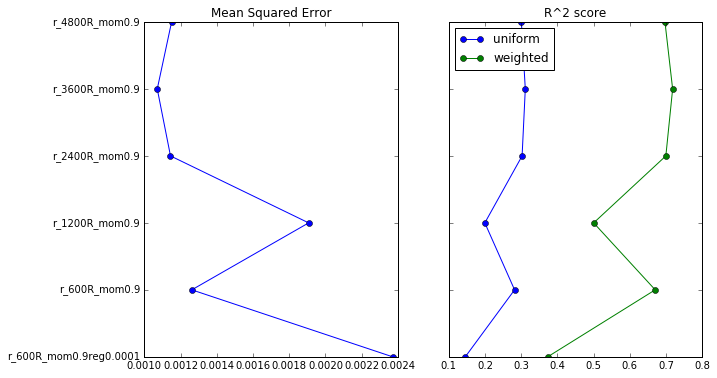

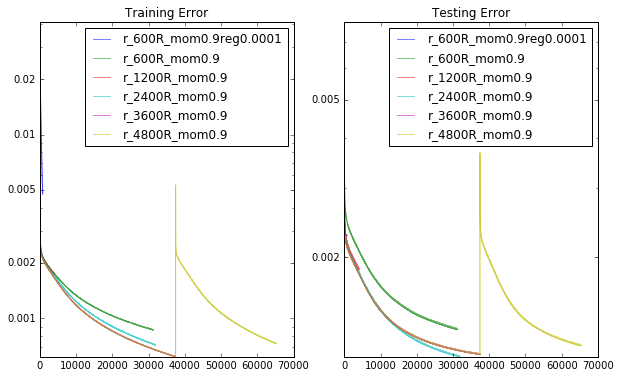

In [65]:
# Initialize regressors
from importlib import reload
reload(nntrain)
trained_regressors = ['r_600R_mom0.9reg0.0001','r_600R_mom0.9',
                      'r_1200R_mom0.9','r_2400R_mom0.9','r_3600R_mom0.9',
                     'r_4800R_mom0.9']
N_r = len(trained_regressors)
r_mlp = [0]*N_r
r_str = [0]*N_r
r_errors=np.empty((70000,4,N_r))
r_errors[:]=np.NAN

# Load regressors
for i,r in enumerate(trained_regressors):
    r_mlp[i], r_str[i], err = pickle.load(open(data_dir + 'regressors/' + r + '.pkl', 'rb'))
    r_errors[:len(err),:,i]      =  err
# Compare them and plot output
nntrain.plot_regressors_scores(r_mlp,r_str,x2,y2,fig_dir + 'compare/','r')
nntrain.plot_model_error_over_time(r_errors, r_str, fig_dir + 'compare/','r')

## Plot test data evaluations

/Users/jgdwyer/Dropbox (MIT)/scripts/nn/src/nnload.py:67: UserWarning: Shifting inputs and outputs one time step so they line up!
  warnings.warn("Shifting inputs and outputs one time step so they line up!")


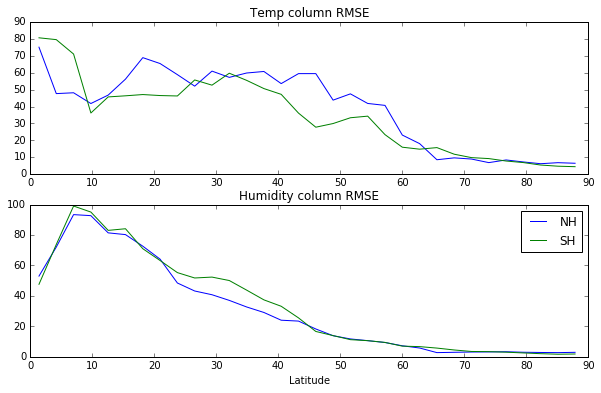

In [45]:
# Load the model we want to do a detailed evaulation for
reload(nnplot)
r_str_eval = 'r_4800R_mom0.9'
r_mlp_eval, _, _ = pickle.load(open(data_dir + 'regressors/' + r_str_eval + '.pkl', 'rb'))

# Set figure path and create directory if it does not exist
figpath = fig_dir + r_str_eval + '/'
if not os.path.exists(figpath):
    os.makedirs(figpath)
    

# Inverse transform output back to physical units
y3_true = scaler_y.inverse_transform(y2)
y3_pred = scaler_y.inverse_transform(r_mlp_eval.predict(x2))

# Plot means and standard deviations
nnplot.plot_means_stds(y3_true, y3_pred, lev, figpath)

# Plot correlation coefficient, explained variance, and rmse
nnplot.plot_error_stats(y3_true, y3_pred, lev, figpath)

# Plot a time series of precipitaiton
nnplot.plot_precip(y3_true, y3_pred, dlev, figpath)

# Plot the enthalpy conservation
nnplot.plot_enthalpy(y3_true, y3_pred, dlev, figpath)

# Plot the rmse vs lat
nnplot.plot_rmse_vs_lat(r_mlp_eval, figpath, data_dir='./data/',minlev=0.0,rainonly=False)


In [ ]:
#     r_mlp.append(build_nn('regress',['Rectifier','Rectifier']            ,[500,500]    ,n_iter,batch_size,'momentum'))
#     r_mlp.append(build_nn('regress',['Rectifier','Rectifier','Rectifier'],[200,200,200],n_iter,batch_size,'momentum'))
#     r_mlp.append(build_nn('regress',['Tanh','Tanh','Tanh']               ,[100,100,100],n_iter,batch_size,'momentum'))
#     r_mlp.append(build_nn('regress',['Tanh','Tanh']                      ,[500,500]    ,n_iter,batch_size,'momentum'))
#     r_mlp.append(build_nn('regress',['Tanh','Tanh']                      ,[200,200]    ,n_iter,batch_size,'momentum'))
#     r_mlp.append(build_nn('regress',['Tanh']                             ,[500]        ,n_iter,batch_size,'momentum'))
#     r_mlp.append(build_nn('regress',['Tanh','Tanh']                      ,[500,500]    ,n_iter,batch_size,'momentum',learning_momentum=0.7))
#     r_mlp.append(build_nn('regress',['Tanh','Tanh']                      ,[500,500]    ,n_iter,batch_size,'sgd'))

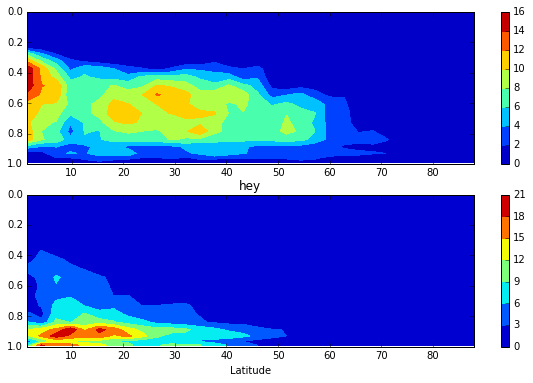

In [59]:
reload(nnplot)
nnplot.plot_contour(tt,qq,lathalf,levnow)
plt.title('hey')
plt.show()

In [63]:
# Plot basic stats about the data
tmean = np.mean(nnload.unpack(y3,'T'))
qmean = np.mean(nnload.unpack(y3,'q'))
print(tmean.shape)
tmean,lathalf = nnload.avg_hem(tmean,lat,0)
qmean,lathalf = nnload.avg_hem(qmean,lat,0)
nnplot.plot_contour(tmean, qmean, lathalf, lev)

()
[  1.39530694   4.18592072   6.97653341   9.76714516  12.55775642
  15.34836483  18.13897133  20.92957497  23.72017479  26.51076889
  29.30135918  32.09194565  34.88252258  37.67308807  40.46364975
  43.25419617  46.04472733  48.83523941  51.62573242  54.41619873
  57.20663071  59.99702072  62.78735352  65.5776062   68.3677597
  71.15775299  73.9475174   76.73690033  79.52560425  82.31291199
  85.0965271   87.86380005]


IndexError: index 1 is out of bounds for size 1

In [151]:
reload(nnplot)
reload(nnload)

Tmean, qmean, rmseT, rmseq, rT, rq = nnload.stats_by_latlev(scaler_x,scaler_y,r_mlp_eval,lat, lev)

/Users/jgdwyer/Dropbox (MIT)/scripts/nn/src/nnload.py:69: UserWarning: Shifting inputs and outputs one time step so they line up!
  warnings.warn("Shifting inputs and outputs one time step so they line up!")


(<matplotlib.figure.Figure at 0x116d974e0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12090b978>)

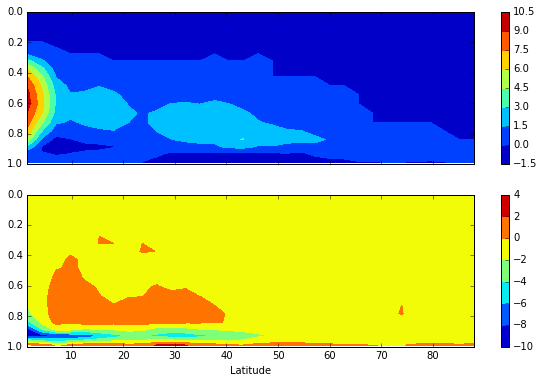

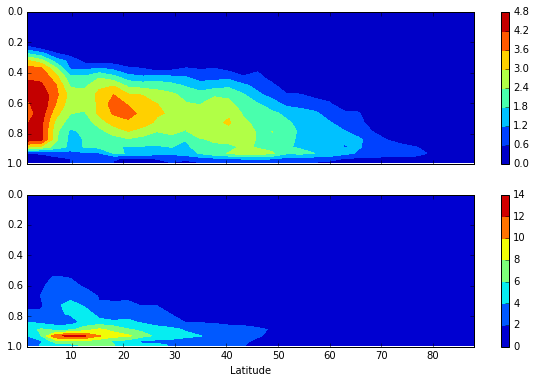

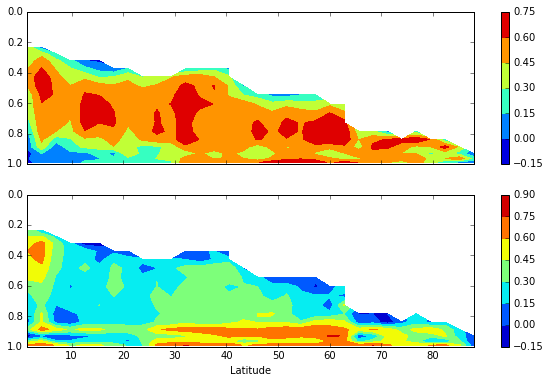

In [152]:
reload(nnplot)
nnplot.plot_contour(Tmean,qmean,lat,lev, avg_hem=True)
nnplot.plot_contour(rmseT,rmseq,lat,lev, avg_hem=True)
nnplot.plot_contour(rT, rq, lat, lev, avg_hem=True)

In [147]:
print(rT[:,48])

[        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan -0.0249666   0.27892372
  0.21211537  0.31264418  0.42731124  0.46191733  0.52287459  0.54696761
  0.61308178  0.55132956  0.43407859  0.39845997  0.36249112  0.51250547]
